In [1]:
import json
import pandas as pd

In [4]:
with open("../data/results_ss.jsonl") as f:
    _results = [json.loads(line) for line in f]

with open("../data/ratings_ss.jsonl") as f:
    ratings = [json.loads(line) for line in f]

In [5]:
results = [result for result in _results if "scale" in result]

In [6]:
len(results), len(_results)

(1709, 1792)

In [7]:
len([
    result for result in results if result["scale"] > 0
])

1640

In [8]:
for x in _results:
    if "scale" in x and x["scale"] == 0:
        print(x)

{'id': 18, 'loss': [9.375, 8.5625, 8.625, 8.9375, 8.625, 8.25, 8.0625, 7.75, 7.5, 7.125, 7.0625, 7.03125, 7.34375, 7.5, 7.28125, 7.34375, 7.25, 7.25, 7.125, 7.3125, 7.28125, 7.25, 7.09375, 7.1875, 7.28125, 7.3125, 7.21875, 7.375, 7.3125, 7.4375, 7.53125, 7.5625, 7.75, 7.71875, 7.84375, 7.875, 8.0, 8.1875, 8.1875, 8.25, 8.375, 8.375, 8.3125, 8.375, 8.4375, 8.4375, 8.375, 8.5, 8.4375, 8.4375, 8.4375, 8.4375, 8.5, 8.4375, 8.4375, 8.5, 8.5, 8.4375, 8.5625, 8.3125, 8.4375, 8.4375, 8.3125, 8.4375], 'scale': 0.0, 'best_loss': 9.375, 'entropy_first': [1.1328125, 2.546875, 1.796875, 0.0400390625, 1.09375, 1.2890625, 1.2734375, 1.0234375, 0.96875, 1.1015625, 1.609375, 1.9375, 1.9296875, 1.78125, 1.9375, 2.03125, 2.25, 2.515625, 2.640625, 2.75, 2.84375, 2.703125, 2.671875, 2.484375, 2.375, 2.234375, 2.359375, 2.125, 2.21875, 2.109375, 2.09375, 2.015625, 1.8828125, 1.8671875, 1.7890625, 1.6328125, 1.6015625, 1.3984375, 1.4296875, 1.3515625, 1.2734375, 1.2421875, 1.3046875, 1.1875, 1.125, 1.046875,

In [9]:
prefix = "The overall rating for all texts is:"

In [10]:
processed_ratings = [
    x for x in ratings if prefix in x["rating"]
]

In [11]:
len(processed_ratings)

1579

In [12]:
processed_ratings = [
    int(x["rating"][len(prefix) + 1:len(prefix) + 2]) for x in processed_ratings
]

In [13]:
sum(processed_ratings) / len(processed_ratings)

0.461051298290057

In [14]:
from collections import Counter
Counter(processed_ratings)

Counter({0: 851, 1: 728})

In [15]:
len(
    [x for x in processed_ratings if x >= 3] 
) / len(processed_ratings)

0.0

In [13]:
import pyarrow.parquet as pq

from transformers import AutoTokenizer
TOKENIZER = "microsoft/Phi-3-mini-4k-instruct"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)

token_table = pq.read_table("tokensv4_hermes.parquet")

layers = [4, 8, 10, 12, 13, 14, 16, 18]

dfs = {
    layer: pq.read_table(f"weights/caches/phi-l{layer}-r4-st0.25x128-activationsv4_hermes.parquet").to_pandas() for layer in layers
}

def make_table(feature, layer, token_range, after_next):
  df = dfs[layer]

  table_feat = df[df["feature"] == feature].copy()
  table_feat = table_feat[table_feat["freq"] > 0].copy()
  table_feat["before"] = table_feat["token"].apply(
      lambda x: tokenizer.decode(token_table[max(0, x - token_range):x+1]["tokens"].to_numpy()))
  table_feat["after"] = table_feat["token"].apply(
      lambda x: "" if not after_next else (tokenizer.decode(token_table[x+1:x+1+after_next]["tokens"].to_numpy()))
  )

  table_feat = table_feat.sort_values(by=["activation"], ascending=False)
  return table_feat 


/home/dmitrii/self-explanation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:

from datasets import load_dataset

dataset = load_dataset("kisate-team/feature-explanations", split="train")


/home/dmitrii/self-explanation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from tqdm.auto import tqdm

In [16]:
# results[]

In [18]:
filtered_ratings = []
for r in tqdm(ratings):
  item = dataset[r["id"]]

  table = make_table(item["feature"], item["layer"], 10, 10)

  # print(table["activation"].head())

  if table["activation"].size > 5 and table["activation"].iloc[0] > 5 and table["freq"].sum() < 0.5:
    filtered_ratings.append(r)

  # filtered_results.append({

100%|██████████| 1664/1664 [00:21<00:00, 77.95it/s]


In [19]:
densities = []
for r in tqdm(ratings):
  if prefix not in r["rating"]:
    continue

  item = dataset[r["id"]]

  table = make_table(item["feature"], item["layer"], 2, 2)

  # print(table["activation"].head())

  if table["activation"].size > 5 and table["activation"].iloc[0] > 5:
    # densities.append((table["activation"].iloc[4], int(r["rating"][len(prefix) + 1:len(prefix) + 2])))
    densities.append((table["freq"].sum(), int(r["rating"][len(prefix) + 1:len(prefix) + 2])))

100%|██████████| 1664/1664 [00:19<00:00, 83.60it/s]


Text(0, 0.5, 'rating')

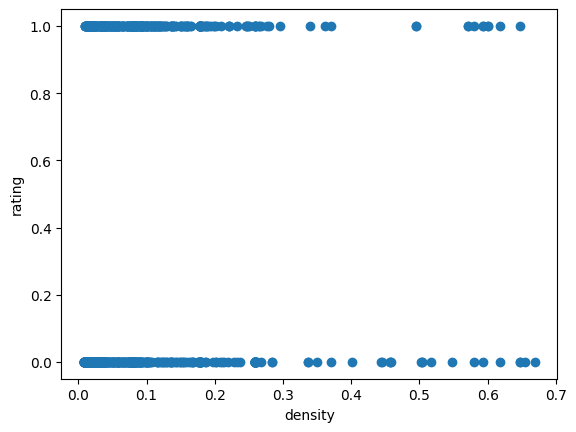

In [26]:
import matplotlib.pyplot as plt

plt.scatter(*zip(*[x for x in densities]))
plt.xlabel("density")
plt.ylabel("rating")
# ax.show()

In [20]:
len(filtered_ratings)

1221

In [21]:
processed_ratings = [
    int(x["rating"][len(prefix) + 1:len(prefix) + 2]) for x in filtered_ratings if prefix in x["rating"]
]

In [22]:
len(processed_ratings)

1208

In [23]:
sum(processed_ratings) / len(processed_ratings)

0.4958609271523179

In [44]:
from collections import Counter
Counter(processed_ratings)

Counter({5: 480, 1: 444, 4: 139, 2: 90, 3: 20})

In [22]:
dataset = [x for x in dataset if x["explanation"] is not None]

In [24]:
def check_explanation(explanation: str):
    if "code" in explanation:
        return False
    if "math" in explanation:
        return False
    if "algorithm" in explanation:
        return False
    return True

In [25]:
filtered_dataset = [
    x for x in dataset if check_explanation(x["explanation"])
]

In [31]:
filtered_ids = [i for i, x in enumerate(dataset) if check_explanation(x["explanation"])]

In [34]:
filtered_ratings = [
    x for x in ratings if prefix in x["rating"]
]

In [35]:
filtered_ratings = [
    x for x in filtered_ratings if x["id"] in filtered_ids
]

In [37]:
filtered_ratings = [
    int(x["rating"][len(prefix) + 1:len(prefix) + 2]) for x in filtered_ratings
]

In [38]:
sum(filtered_ratings) / len(filtered_ratings)

2.8854087089381206

In [14]:
with open("gen_explanations_new.jsonl") as f:
    gen_explanations = [json.loads(line) for line in f]

In [19]:
for x, e in zip(ratings, gen_explanations):
    if prefix + " 1" in x["rating"]:
        # print(x["rating"])
        
        print(dataset[x["id"]]["explanation"])
        for i, k in enumerate(e["explanation"]):
            print(
                f"{i + 1}. {k}"
            )
        print()

mentions of geographic locations
1.  "a preposition or a term used to denote a specific location, place, or setting, particularly in written English." However, as it stands, "by itself," the word "by" functions as
2.  "in or at the location or area known as 'City of San Francisco' within the state of California in the United States of America." The symbol "@" is often used as the "at" symbol
3.  "location" or "reference point." However, as it stands, it's an incomplete phrase. "A" or "the" would typically precede "district," turning it into "the
4.  "The name of a specific location represented by the words 'City', 'Street', or 'Place', followed by the word 'District' to specify a more precise area within a city." However

specific factual information or data points in the document
1.  "in charge of" or "in control of." It is often used to refer to someone who has authority or leadership in a particular situation or context. For example, you might say, "She is
2.  "younger brother" or "

In [20]:
dataset = [x for x in dataset]

In [21]:
new_columns = ["gen_explanations", "rating", "loss", "scale"]
for x in dataset:
    x.update({k: None for k in new_columns}) 

In [22]:
for r in _results:
    if "scale" not in r:
        continue
    dataset[r["id"]]["scale"] = r["scale"]
    dataset[r["id"]]["loss"] = r["loss"]

In [23]:
for r in ratings:
    if prefix not in r["rating"]:
        continue
    dataset[r["id"]]["rating"] = int(r["rating"][len(prefix) + 1:len(prefix) + 2])

In [24]:
for r in gen_explanations:
    dataset[r["id"]]["gen_explanations"] = r["explanation"]

In [25]:
with open("rich_dataset_new.jsonl", "a") as f:
    for x in dataset:
        f.write(json.dumps(x) + "\n")

In [26]:
dataset = load_dataset("kisate-team/feature-explanations", split="train")

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 894.50it/s]
Generating train split: 1791 examples [00:00, 73808.41 examples/s]


In [29]:
dataset[1]

{'layer': 12,
 'version': 4,
 'feature': 27228,
 'type': 'location_country',
 'explanation': 'mentions of geographic locations',
 'gen_explanations': [' "a preposition or a term used to denote a specific location, place, or setting, particularly in written English." However, as it stands, "by itself," the word "by" functions as',
  ' "in or at the location or area known as \'City of San Francisco\' within the state of California in the United States of America." The symbol "@" is often used as the "at" symbol',
  ' "location" or "reference point." However, as it stands, it\'s an incomplete phrase. "A" or "the" would typically precede "district," turning it into "the',
  ' "The name of a specific location represented by the words \'City\', \'Street\', or \'Place\', followed by the word \'District\' to specify a more precise area within a city." However'],
 'rating': 1,
 'loss': [8.0625,
  7.15625,
  6.46875,
  6.3125,
  7.71875,
  7.96875,
  8.0,
  7.71875,
  7.53125,
  7.40625,
  7.312

In [112]:
dataset[100]

{'layer': 14,
 'version': 4,
 'feature': 48948,
 'type': 'location_language',
 'explanation': 'phrases that describe a problem or question that requires identifying an outlier or finding a pattern',
 'gen_explanations': [' "the condition or state" of something, typically related to a game or sporting event. In the context of games or sports, "the position or place of a player on the field or court"',
  ' "a diagram representing a playing field in a sport or game," typically outlined in lines. It can also refer to the physical playing surface on which a game is played, such as a soccer pitch',
  ' "a surface or shape on which something is drawn, painted, or designed." In various contexts, it can refer to a game board (like in chess or checkers), a stage for a',
  ' "a pattern on a playing surface," like a board or a pool table. It can also refer to a specific part of a game or sport where a player must place a piece or make a move.'],
 'rating': 1,
 'loss': [4.0,
  4.375,
  3.4375,
  3.